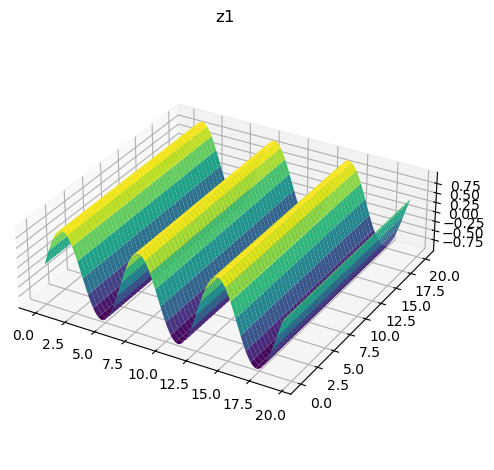

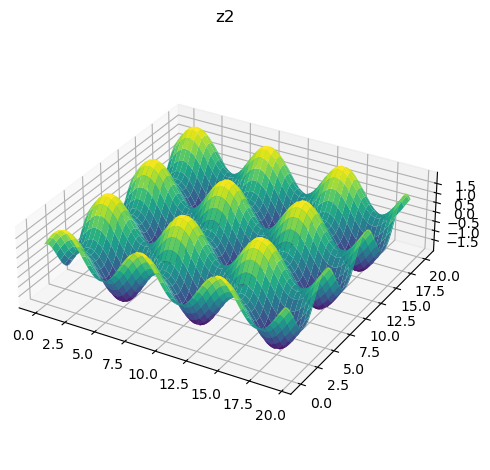

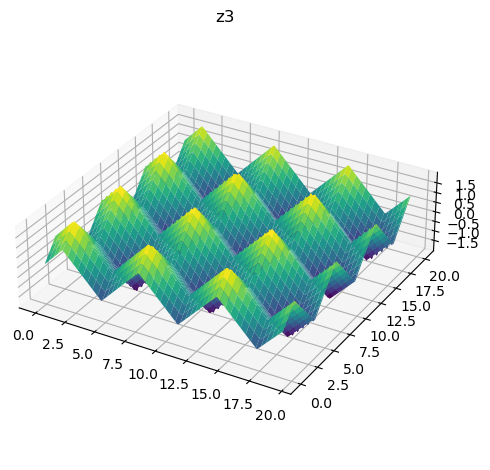

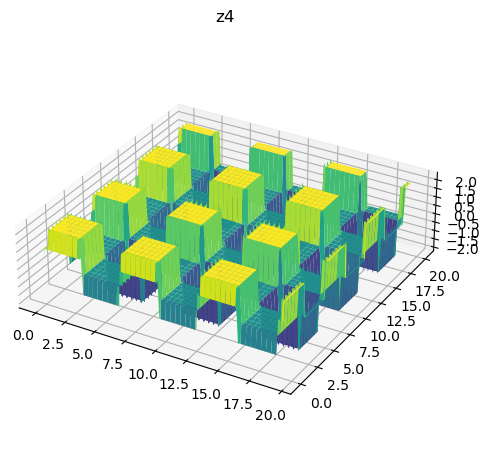

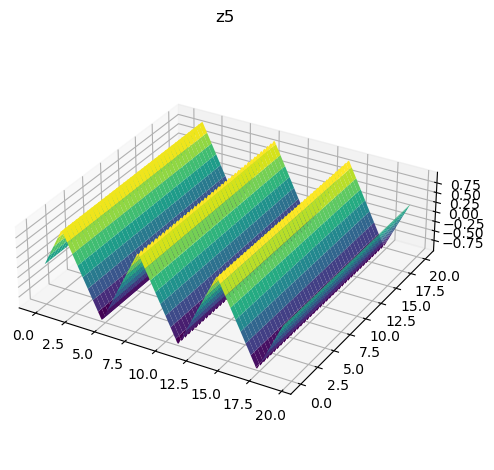

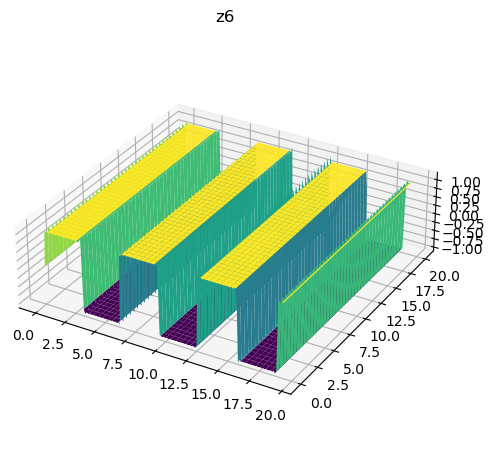

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create meshgrid
x_vals = np.arange(0, 6 * np.pi +0.5, 0.1)
y_vals = np.arange(0, 6 * np.pi + 1.2, 0.1)
x, y = np.meshgrid(x_vals, y_vals)

# z1
A1 = 1
A2 = 0
f1 = 1
f2 = 1
phi = np.pi / 2
z1 = A1 * np.sin(f1 * x) + A2 * np.sin(f2 * y + phi)

# z2
A2 = 1
z2 = A1 * np.sin(f1 * x) + A2 * np.sin(f2 * y + phi)

# z3
z3 = np.zeros_like(x)
N = 25
for ii in range(1, N + 1, 2):
    A1 = (8 / np.pi**2) * ((-1)**((ii - 1) // 2)) / ii**2
    A2 = A1
    f1 = f2 = ii
    phi = 0
    z3 += A1 * np.sin(f1 * x) + A2 * np.sin(f2 * y + phi)

# z4
z4 = np.zeros_like(x)
N = 101
for ii in range(1, N + 1, 2):
    A1 = 4 / (np.pi * ii)
    A2 = A1
    f1 = f2 = ii
    phi = 0
    z4 += A1 * np.sin(f1 * x) + A2 * np.sin(f2 * y + phi)

# z5
z5 = np.zeros_like(x)
N = 25
for ii in range(1, N + 1, 2):
    A1 = (8 / np.pi**2) * ((-1)**((ii - 1) // 2)) / ii**2
    A2 = 0
    f1 = f2 = ii
    phi = 0
    z5 += A1 * np.sin(f1 * x) + A2 * np.sin(f2 * y + phi)

# z6
z6 = np.zeros_like(x)
N = 101
for ii in range(1, N + 1, 2):
    A1 = 4 / (np.pi * ii)
    A2 = 0
    f1 = f2 = ii
    phi = 0
    z6 += A1 * np.sin(f1 * x) + A2 * np.sin(f2 * y + phi)

# Plotting
def plot_surface(x, y, z, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, edgecolor='none', cmap='viridis')
    ax.set_title(title)
    ax.set_box_aspect([1, 1, 0.3])  # Keep axis equal
    plt.tight_layout()

plot_surface(x, y, z1, 'z1')
plot_surface(x, y, z2, 'z2')
plot_surface(x, y, z3, 'z3')
plot_surface(x, y, z4, 'z4')
plot_surface(x, y, z5, 'z5')
plot_surface(x, y, z6, 'z6')

plt.show()

zs=[z1,z2,z3,z4,z5,z6]


## 3D print

In [14]:
import trimesh
from scipy.spatial import Delaunay

def surface_to_stl(x, y, z, filename='output.stl', height_offset=0):
    # Flatten the meshgrid and shift z if needed
    vertices = np.column_stack((x.ravel(), y.ravel(), z.ravel() + height_offset))
    
    # Create faces using row and column indexing
    n_rows, n_cols = x.shape
    faces = []
    for i in range(n_rows - 1):
        for j in range(n_cols - 1):
            idx = i * n_cols + j
            faces.append([idx, idx + 1, idx + n_cols])
            faces.append([idx + 1, idx + n_cols + 1, idx + n_cols])
    
    # Convert to numpy arrays
    faces = np.array(faces)
    
    # Create mesh and export
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    mesh.export(filename)
    print(f"Exported {filename}")

def export_surface_to_solid_block(x, y, z, filename="solid_block.stl", thickness=5.0):
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    assert x.shape == y.shape == z.shape

    # Flatten to 1D for triangulation
    x_flat = x.ravel()
    y_flat = y.ravel()
    z_flat = z.ravel()
    top_vertices = np.column_stack((x_flat, y_flat, z_flat))

    # Triangulate x-y
    tri = Delaunay(np.column_stack((x_flat, y_flat)))
    top_faces = tri.simplices

    # Create bottom vertices (same x, y, but lowered z)
    bottom_vertices = np.column_stack((x_flat, y_flat, np.full_like(z_flat, z.min() - thickness)))

    # Join vertices
    vertices = np.vstack((top_vertices, bottom_vertices))
    n_points = len(top_vertices)

    # Top and bottom faces
    bottom_faces = tri.simplices[:, ::-1] + n_points  # flip to keep normal consistent

    # --- Find boundary edges (edges belonging to only 1 triangle) ---
    edge_count = {}
    for face in tri.simplices:
        for i in range(3):
            a, b = sorted((face[i], face[(i + 1) % 3]))
            edge = (a, b)
            edge_count[edge] = edge_count.get(edge, 0) + 1

    boundary_edges = [edge for edge, count in edge_count.items() if count == 1]

    # Side faces (two triangles per boundary edge)
    side_faces = []
    for a, b in boundary_edges:
        a_bot = a + n_points
        b_bot = b + n_points
        # Triangle 1: a, b, b_bot
        side_faces.append([a, b, b_bot])
        # Triangle 2: a, b_bot, a_bot
        side_faces.append([a, b_bot, a_bot])

    # Combine all faces
    faces = np.vstack((top_faces, bottom_faces, side_faces))

    # Export as mesh
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=True)
    mesh.export(filename)
    print(f"Exported watertight solid block to {filename}")

In [15]:
export_surface_to_solid_block(x, y, z3, filename='C:/Users/dexte/Documents/GitHub/3D-textures/Generator/objects/z3_surface.stl')
# 
# surface_to_stl(x, y, z3, filename='C:/Users/dexte/Documents/GitHub/3D-textures/Generator/objects/z3_surface.stl', height_offset=10)

Exported watertight solid block to C:/Users/dexte/Documents/GitHub/3D-textures/Generator/objects/z3_surface.stl


#gen all

In [21]:
for i,_ in enumerate(zs):
    export_surface_to_solid_block(x, y, _, filename='C:/Users/dexte/Documents/GitHub/3D-textures/Generator/objects/z'+str(i)+'_surface.stl')


Exported watertight solid block to C:/Users/dexte/Documents/GitHub/3D-textures/Generator/objects/z0_surface.stl
Exported watertight solid block to C:/Users/dexte/Documents/GitHub/3D-textures/Generator/objects/z1_surface.stl
Exported watertight solid block to C:/Users/dexte/Documents/GitHub/3D-textures/Generator/objects/z2_surface.stl
Exported watertight solid block to C:/Users/dexte/Documents/GitHub/3D-textures/Generator/objects/z3_surface.stl
Exported watertight solid block to C:/Users/dexte/Documents/GitHub/3D-textures/Generator/objects/z4_surface.stl
Exported watertight solid block to C:/Users/dexte/Documents/GitHub/3D-textures/Generator/objects/z5_surface.stl
